**Model**

In [5]:
#Imports

from pathlib import Path
import torch, os
import matplotlib.pyplot as plt
import torchvision.transforms as t
from torch import nn, optim

In [12]:
# Data preprocessing
train_path = Path.cwd() / "train"
test_path = Path.cwd() / "val"

from torch.utils.data import Dataset
from itertools import chain
from PIL import Image
#from natsort import natsorted

class Data(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        self.all_imgs = os.listdir(main_dir)
        #self.total_imgs = natsorted(all_imgs)
    
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])

        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

from torchvision.transforms import Compose
transform = Compose([t.ToTensor()])
# YOUR CODE HERE

example_dataset = Data(train_path, transform)
img = example_dataset[2]
print(len(example_dataset))

3455


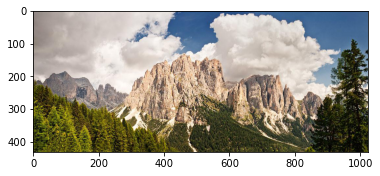

In [14]:
def display_image(axis, image_tensor):
    """Display a tensor as an image
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

# Example usage
_, axis = plt.subplots()
some_random_index = 453
# Here we use the __getitem__ method as a "magic" method.
# Implementing it for a class, enables square bracket '[]' indexing
image_tensor = example_dataset[some_random_index]
display_image(axis, image_tensor)